# Tutorial 5: Visualizing Synthetic Grids with Geo-Referencing
This tutorial focuses on visualizing the synthetic networks you generated in previous steps.

We will take the raw .csv sample data and the pandapower network topology and combine them with geographic data to create maps of:

1) Phase Allocation & Topology: Seeing the phase balancing across the grid.

2) Active power across all phases

3) Reliability Metrics: Visualizing Failure Frequency (CAIFI) and Duration (CAIDI) heatmaps.

4) Line Impedance: Inspecting the Resistance (R) and Reactance (X) of the lines.

In [8]:
import os
import json
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import our custom Bayesian model classes

from bayesgrid import BayesianPowerModel, BayesianFrequencyModel, BayesianDurationModel, BayesianImpedanceModel

from bayesgrid import create_osm_pandapower_network,save_bus_metric_samples,save_power_phase_samples,save_impedance_samples




print("Libraries imported successfully.")

Libraries imported successfully.


# Step 1: Defining the Network and Data Source

In this step, we define the inputs required for visualization. 

**Important Prerequisites:**
This tutorial assumes you have already completed **Tutorial 2 (Synthetic grids anywhere with OpenStreetMaps)**. 
Specifically, you must have:
1.  Generated a synthetic grid.
2.  Saved the network topology (the `pandapower` network).
3.  Saved the synthetic data samples (CSVs) in an output folder.

We will now load this pre-generated network and define the folder where our Bayesian models stored their results.

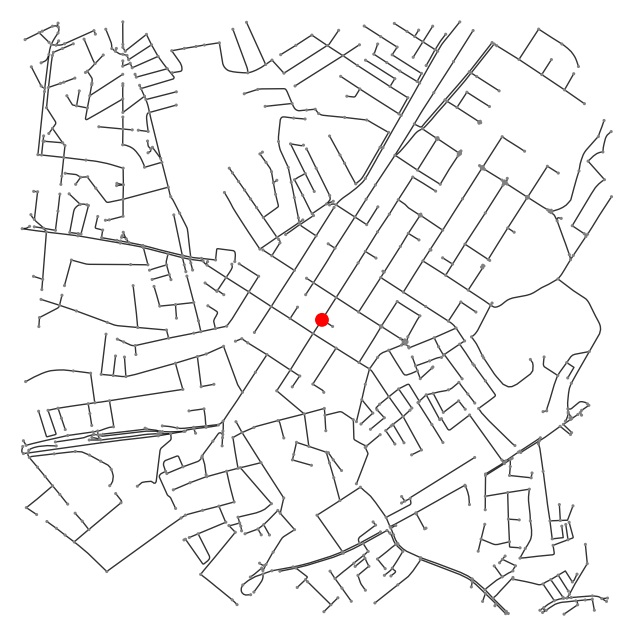

In [25]:

SYNTHETIC_DATA_FOLDER = 'new_osm_synthetic_net' # Folder to save our results
net = pp.from_pickle(os.path.join(SYNTHETIC_DATA_FOLDER,'pandapower_network.p'))

# Keep these for the next steps
source_bus = net.ext_grid.bus.iloc[0] # This will be 0
graph_from_net = pn.create_nxgraph(net)



substation_node = net.bus.name.iloc[source_bus] # Get original osmnx node ID

# --- 1. Prepare Node Colors and Sizes ---
node_colors = []
node_sizes = []
for node in tree_graph.nodes():
    if str(node) == substation_node:
        node_colors.append('red')   # Highlight color for the substation
        node_sizes.append(100)      # Make it larger
    else:
        node_colors.append('gray')  # Color for other nodes
        node_sizes.append(5)        # Make other nodes small

# --- 2. Create and Customize the Plot ---
fig, ax = ox.plot_graph(
    tree_graph,
    node_color=node_colors,
    node_size=node_sizes,
    node_zorder=2,
    edge_color='black',
    edge_linewidth=1.0,
    edge_alpha=0.8,
    bgcolor='white',
    show=False,
    close=False
)


In [26]:
# 1. Load the Base Network (Topology & Geo)
# Use the same network you used for generation

# 2. Define Data Paths
# Point to the folder where you saved your samples


print(f"Loading synthetic samples from: {SYNTHETIC_DATA_FOLDER}")
df_power = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_power_and_phase_SAMPLES.csv'))
df_freq = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_frequency_SAMPLES.csv'))
df_dur = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'bus_duration_SAMPLES.csv'))
df_imp = pd.read_csv(os.path.join(SYNTHETIC_DATA_FOLDER, 'line_impedance_SAMPLES.csv'))

print("Data loaded successfully.")

Loading synthetic samples from: new_osm_synthetic_net
Data loaded successfully.


## Step 2: Process Geo-Coordinates

`pandapower` often stores coordinates in a JSON string format (e.g., `{"coordinates": [...], "type": "Point"}`). For plotting with `networkx` and `matplotlib`, we need a simple dictionary: `{bus_id: [x, y]}`.

We'll define a helper function to handle this conversion automatically.

In [30]:
def get_bus_geo_dict(net):
    """
    Extracts geographic coordinates from a pandapower network.
    Handles both simple 'x/y' columns and JSON 'geo' columns.
    
    Returns:
        dict: {bus_index: [x, y]}
    """
    bus_geo = {}
    
    if 'geo' in net.bus.columns:
        for idx, row in net.bus.iterrows():
            geo_str = row['geo']
            if pd.isna(geo_str):
                continue
            try:
                # Parse the JSON string
                # e.g. '{"coordinates":[-51.23, -21.04], "type":"Point"}'
                geo_data = json.loads(geo_str)
                coords = geo_data['coordinates']
                # GeoJSON is usually [lon, lat], i.e., [x, y]
                bus_geo[idx] = [coords[0], coords[1]]
            except (json.JSONDecodeError, KeyError, TypeError):
                pass
                
    # Case 3: Fallback to generic layout if no geo data exists
    if not bus_geo:
        print("Warning: No geo data found. Using generic spring layout.")
        graph = pp.topology.create_nxgraph(net)
        bus_geo = nx.spring_layout(graph)
        
    return bus_geo

# Create the geo-dictionary and graph
bus_geo_data = get_bus_geo_dict(net)
graph_from_net = pp.topology.create_nxgraph(net)
source_bus = net.ext_grid.bus.iloc[0]

print(f"Extracted coordinates for {len(bus_geo_data)} buses.")
print(f"Example coord for bus {source_bus}: {bus_geo_data[source_bus]}")

Extracted coordinates for 951 buses.
Example coord for bus 0: [-46.701839, -23.649094]


## Step 3: Select a Sample to Visualize

Since our CSVs contain many stochastic samples (e.g., 100 variations), we must select **one** specific sample ID to visualize. This allows you to see how a single, consistent realization of the network looks.


In [35]:
# Choose which sample to visualize (0 to N_SAMPLES - 1)
SAMPLE_ID = 30

print(f"Filtering data for Sample ID: {SAMPLE_ID}")

# Filter DataFrames
sample_power = df_power[df_power['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_freq = df_freq[df_freq['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_dur = df_dur[df_dur['sample_id'] == SAMPLE_ID].set_index('bus_id')
sample_imp = df_imp[df_imp['sample_id'] == SAMPLE_ID].set_index('line_id')

print("Data filtered.")

Filtering data for Sample ID: 30
Data filtered.


## Visualization 1: Phase Allocation

This plot colors each node based on its allocated phase (A, B, C, AB, etc.). It helps visualize phase balance and branching.


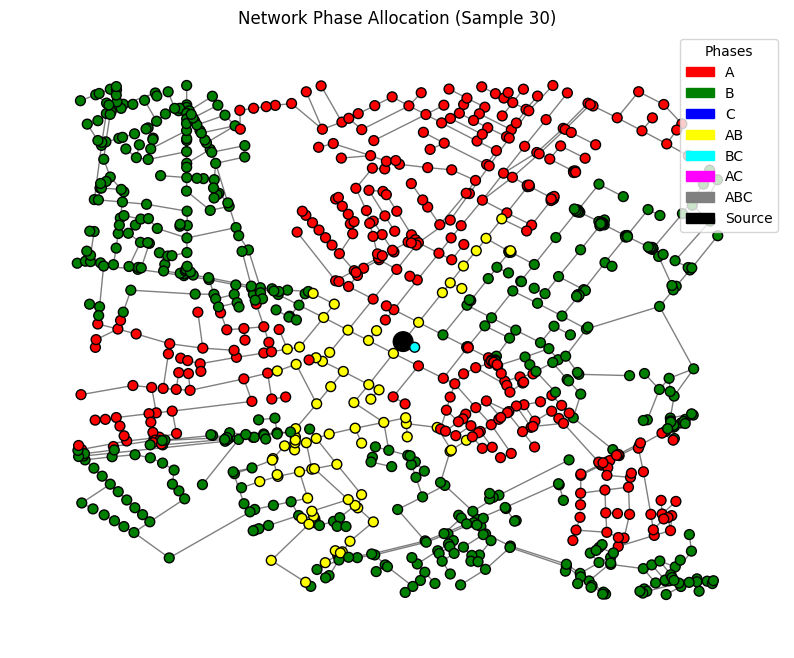

In [36]:
# --- 1. Map Phases to Colors ---
# Define standard colors for phases
phase_colors = {
    'A': 'red', 'B': 'green', 'C': 'blue',
    'AB': 'yellow', 'BC': 'cyan', 'AC': 'magenta', # Note: using AC for consistency
    'ABC': 'gray', 'nan': 'black'
}

node_colors = []
for node in graph_from_net.nodes:
    if node == source_bus:
        node_colors.append('black') # Source is black
    else:
        try:
            phase = str(sample_power.loc[node, 'phase'])
            # Handle potential 'CA' vs 'AC' naming differences
            if phase == 'CA': phase = 'AC'
            node_colors.append(phase_colors.get(phase, 'black'))
        except KeyError:
            node_colors.append('black')

# --- 2. Plotting ---
plt.figure(figsize=(10, 8))

# Draw edges
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, edge_color='black', alpha=0.5)

# Draw nodes
nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data,
    node_size=[200 if n==source_bus else 50 for n in graph_from_net.nodes],
    node_color=node_colors,
    edgecolors='black' # Add border to nodes
)

# Create Custom Legend
handles = [
    Circle(0, color='red', label='A'),
    Circle(0, color='green', label='B'),
    Circle(0, color='blue', label='C'),
    Circle(0, color='yellow', label='AB'),
    Circle(0, color='cyan', label='BC'),
    Circle(0, color='magenta', label='AC'),
    Circle(0, color='gray', label='ABC'),
    Circle(0, color='black', label='Source')
]
plt.legend(handles=handles, loc='best', title="Phases")
plt.title(f"Network Phase Allocation (Sample {SAMPLE_ID})")
plt.axis('off')
plt.show()

## Visualization 2: Power Demand per Phase
This visualization plots the Active Power (kW) demand for each phase side-by-side.

Crucial Detail: We calculate a global minimum and maximum power across all three phases. This ensures that a specific color (e.g., bright orange) represents the same amount of kW in all three plots, allowing you to visually compare the load balance between Phase A, B, and C.

Power Range: 0.00 kW to 3242.75 kW


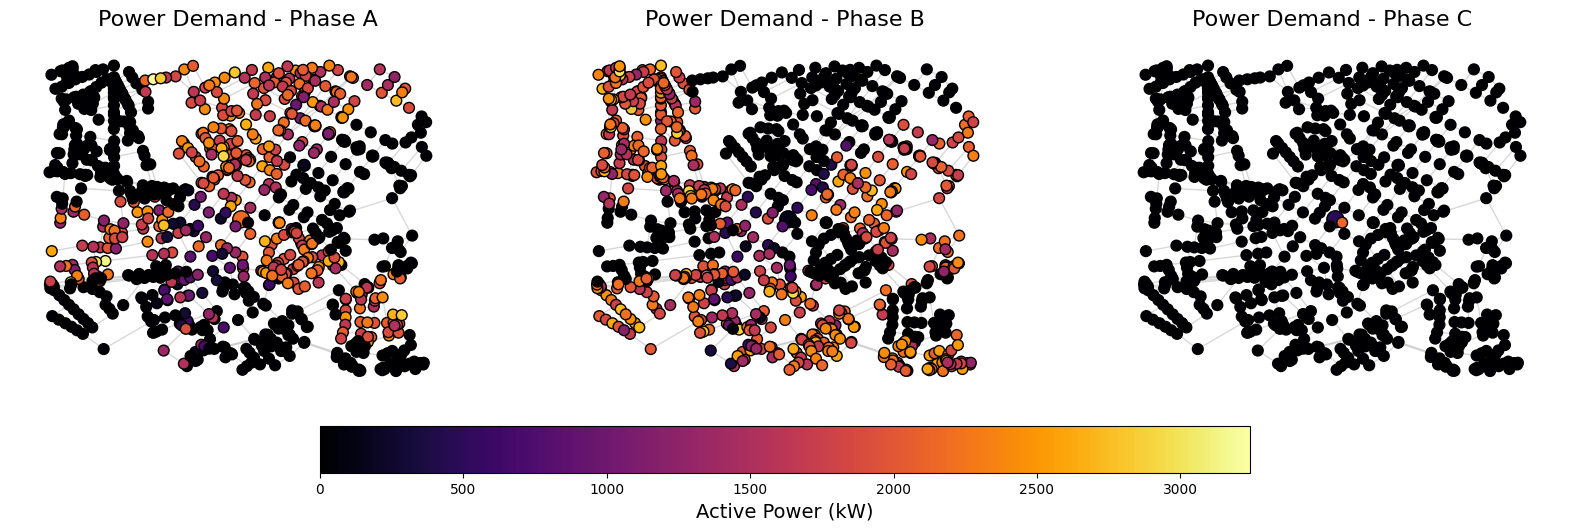

In [37]:
# --- 1. Prepare Data ---
# Extract power values for each phase, aligned with graph nodes
p_a_values = [sample_power.loc[n, 'P_A'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]
p_b_values = [sample_power.loc[n, 'P_B'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]
p_c_values = [sample_power.loc[n, 'P_C'] if n in sample_power.index else 0 
              for n in graph_from_net.nodes]

# --- 2. Calculate Shared Limits ---
# We need a single min/max for all 3 plots to make colors comparable
all_p_values = p_a_values + p_b_values + p_c_values
p_min = min(all_p_values)
p_max = max(all_p_values)

print(f"Power Range: {p_min:.2f} kW to {p_max:.2f} kW")

# --- 3. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Helper list for looping
phases_data = [
    ('Phase A', p_a_values, axes[0]),
    ('Phase B', p_b_values, axes[1]),
    ('Phase C', p_c_values, axes[2])
]

for phase_name, p_values, ax in phases_data:
    # Draw faint edges for context
    nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax, 
                           edge_color='gray', alpha=0.3)
    
    # Draw nodes colored by power
    nodes = nx.draw_networkx_nodes(
        graph_from_net, pos=bus_geo_data, ax=ax,
        node_size=[150 if n==source_bus else 60 for n in graph_from_net.nodes],
        node_color=p_values,
        cmap=plt.cm.inferno, # 'inferno' is great for intensity (black->red->yellow)
        vmin=p_min, vmax=p_max, # <--- Shared scale
        edgecolors='black'
    )
    ax.set_title(f"Power Demand - {phase_name}", fontsize=16)
    ax.axis('off')

# --- 4. Add Shared Colorbar ---
# Create a dummy mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=p_min, vmax=p_max))
sm.set_array([])

# Place colorbar at the bottom
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.6, location='bottom', pad=0.05)
cbar.set_label('Active Power (kW)', fontsize=14)

plt.show()

## Visualization 3: Reliability Heatmaps (CAIFI & CAIDI)

This section generates two heatmaps: one for Failure Frequency (CAIFI) and one for Failure Duration (CAIDI).


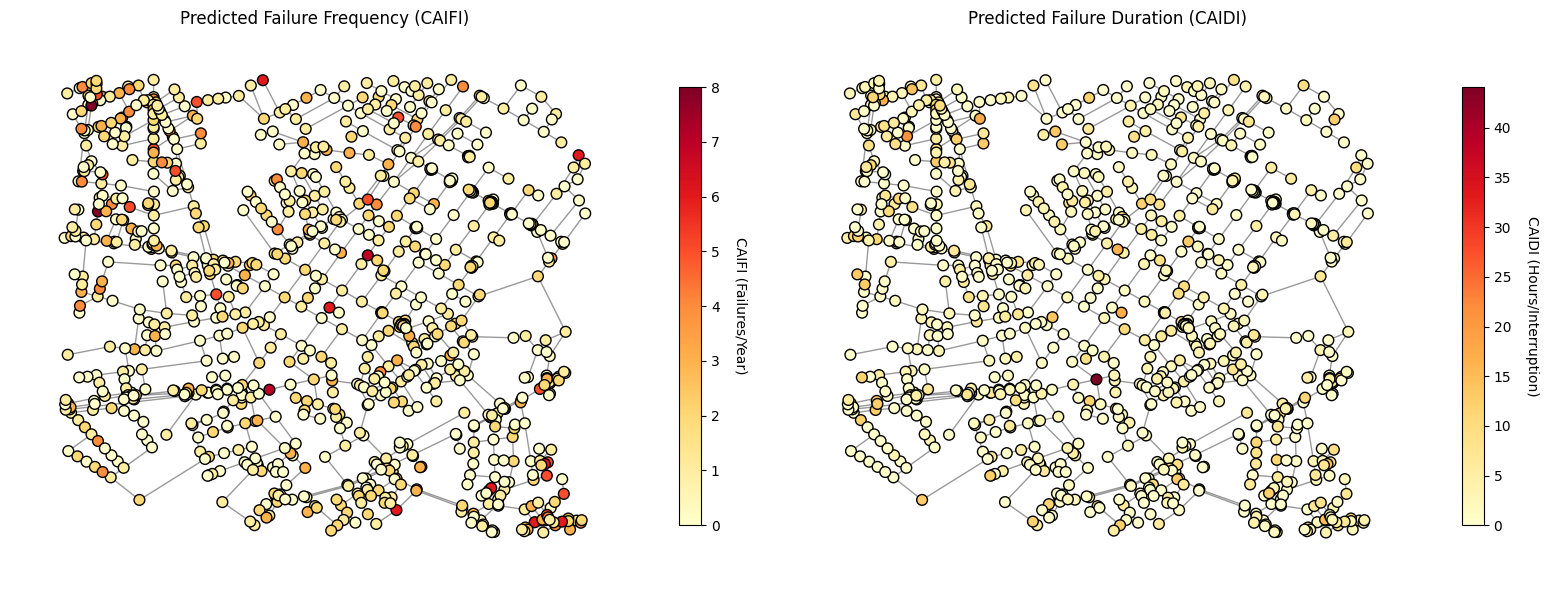

In [38]:
# --- Prepare Data for Plotting ---
# Map the values to the graph nodes (ensuring order matches graph.nodes)
freq_values = [sample_freq.loc[n, 'CAIFI_FIC'] if n in sample_freq.index else 0 
               for n in graph_from_net.nodes]

dur_values = [sample_dur.loc[n, 'CAIDI_DIC'] if n in sample_dur.index else 0 
              for n in graph_from_net.nodes]

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Frequency (CAIFI)
ax1 = axes[0]
nodes1 = nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data, ax=ax1,
    node_size=60, node_color=freq_values,
    cmap=plt.cm.YlOrRd, edgecolors='black'
)
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax1, edge_color='black', alpha=0.4)
cbar1 = plt.colorbar(nodes1, ax=ax1, shrink=0.8)
cbar1.set_label('CAIFI (Failures/Year)', rotation=270, labelpad=20)
ax1.set_title("Predicted Failure Frequency (CAIFI)")
ax1.axis('off')

# Plot 2: Duration (CAIDI)
ax2 = axes[1]
nodes2 = nx.draw_networkx_nodes(
    graph_from_net, pos=bus_geo_data, ax=ax2,
    node_size=60, node_color=dur_values,
    cmap=plt.cm.YlOrRd, edgecolors='black'
)
nx.draw_networkx_edges(graph_from_net, pos=bus_geo_data, ax=ax2, edge_color='black', alpha=0.4)
cbar2 = plt.colorbar(nodes2, ax=ax2, shrink=0.8)
cbar2.set_label('CAIDI (Hours/Interruption)', rotation=270, labelpad=20)
ax2.set_title("Predicted Failure Duration (CAIDI)")
ax2.axis('off')

plt.tight_layout()
plt.show()

## Visualization 4: Line Impedance (R & X)

Here we visualize the electrical properties of the lines. Since 3-phase lines are physically thicker/different than 1-phase lines, we will scale the **edge width** based on the number of phases.

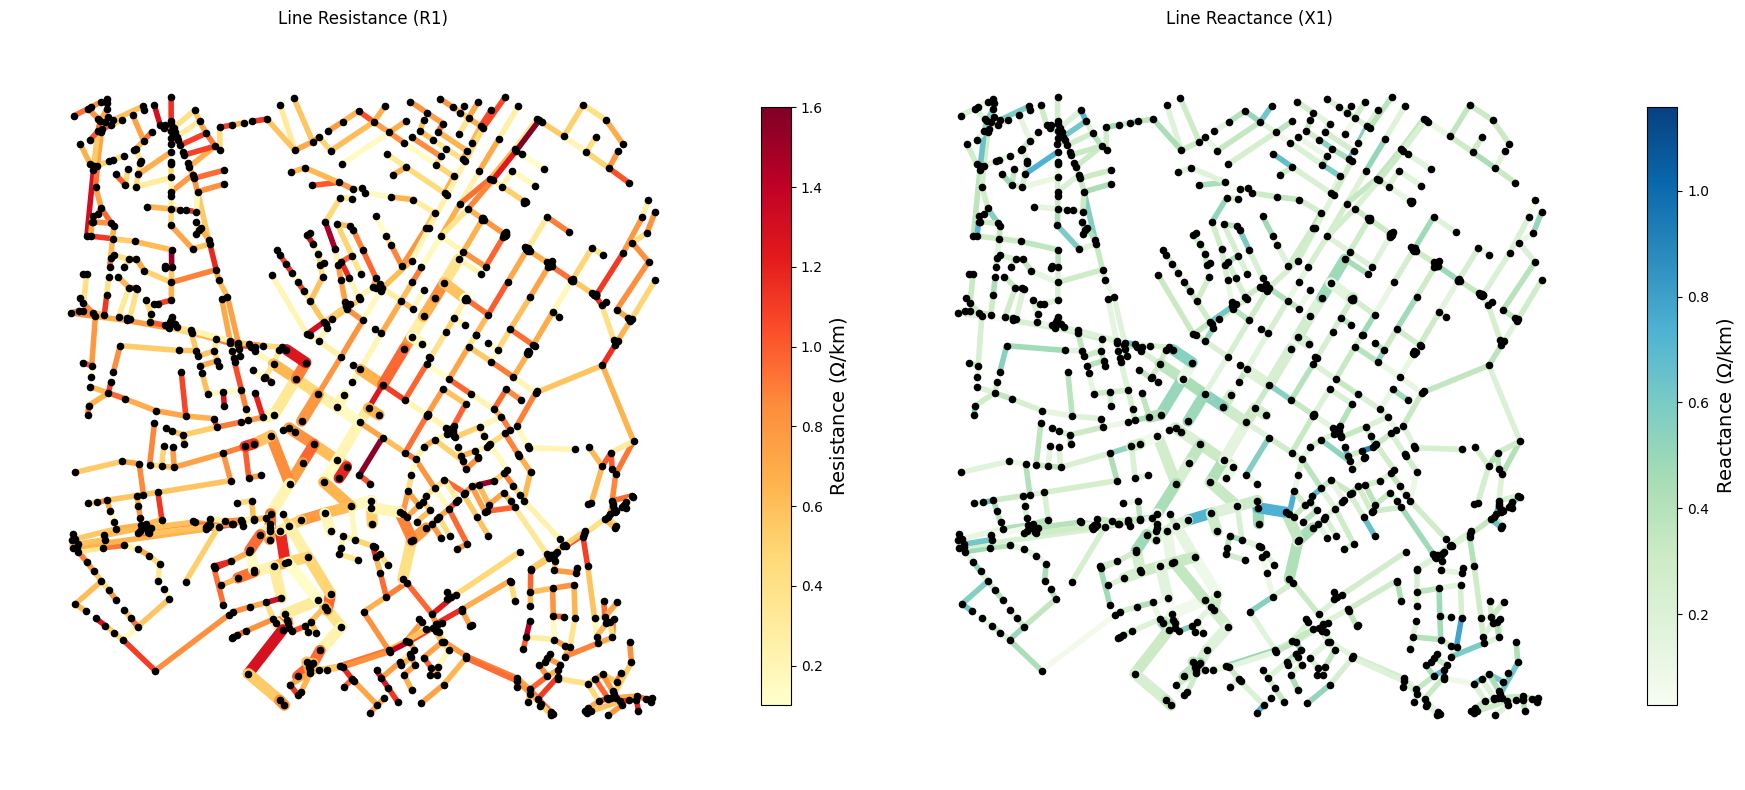

In [39]:
# --- 1. Prepare Edge Widths (Based on Phases) ---
# Helper to count phases
def get_phase_count(phase_str):
    if pd.isna(phase_str): return 1
    return len(str(phase_str).replace('ABC', '3')) 

phase_count_to_width = {1: 4.0, 2: 8, 3: 12} # Adjusted for borders

# Calculate width for each edge in the graph
edge_widths = []
for u, v, _ in graph_from_net.edges:
    # Find the phase of the *downstream* node (approximate line phase)
    # We use 'to_bus' phase as a proxy for the line
    try:
        phase_str = sample_power.loc[v, 'phase']
        phase_count = get_phase_count(phase_str)
        width = phase_count_to_width[phase_count]
    except KeyError:
        width = 1.0
    edge_widths.append(width)

# --- 2. Prepare Edge Colors (R and X values) ---
# Map line indices to graph edges
# Note: pandapower graph edges are usually (from_bus, to_bus, key) or just (u, v)
# We iterate through net.line to match R/X values to specific edges
r_values = []
x_values = []

# Create a map of (u, v) -> index to ensure order
edge_to_idx = {edge[0:2]: i for i, edge in enumerate(graph_from_net.edges)}
r_ordered = [0.0] * len(graph_from_net.edges)
x_ordered = [0.0] * len(graph_from_net.edges)

for idx, row in net.line.iterrows():
    u, v = row['from_bus'], row['to_bus']
    
    # Check if edge exists in graph (it should)
    if graph_from_net.has_edge(u, v):
        # Get the integer index of this edge in the graph list
        # Note: graph edges might be (u, v) or (v, u) since it's undirected
        edge_key = (u, v) if (u, v) in edge_to_idx else (v, u)
        
        if edge_key in edge_to_idx:
            list_idx = edge_to_idx[edge_key]
            
            # Get R/X from sample
            try:
                r_ordered[list_idx] = sample_imp.loc[idx, 'R1_ohm_per_km']
                x_ordered[list_idx] = sample_imp.loc[idx, 'X1_ohm_per_km']
            except KeyError:
                pass

# --- 3. Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot R1
ax1 = axes[0]
nx.draw_networkx_nodes(graph_from_net, pos=bus_geo_data, ax=ax1, node_size=20, node_color='black')
edges1 = nx.draw_networkx_edges(
    graph_from_net, pos=bus_geo_data, ax=ax1,
    edge_color=r_ordered, width=edge_widths,
    edge_cmap=plt.cm.YlOrRd
)
cbar1 = plt.colorbar(edges1, ax=ax1, shrink=0.8)
cbar1.set_label(r'Resistance ($\Omega$/km)', fontsize=14)
ax1.set_title("Line Resistance (R1)")
ax1.axis('off')

# Plot X1
ax2 = axes[1]
nx.draw_networkx_nodes(graph_from_net, pos=bus_geo_data, ax=ax2, node_size=20, node_color='black')
edges2 = nx.draw_networkx_edges(
    graph_from_net, pos=bus_geo_data, ax=ax2,
    edge_color=x_ordered, width=edge_widths,
    edge_cmap=plt.cm.GnBu
)
cbar2 = plt.colorbar(edges2, ax=ax2, shrink=0.8)
cbar2.set_label(r'Reactance ($\Omega$/km)', fontsize=14)
ax2.set_title("Line Reactance (X1)")
ax2.axis('off')

plt.tight_layout()
plt.show()